# TimescaleDB Benchmarks – Big Experiments

## Packages

In [1]:
from fabric import ThreadingGroup, Connection
from chi import server, ssh
import os
import warnings
import time
import sys

sys.path.append("../../scripts")
from utilities import *

warnings.filterwarnings("ignore")


## Configurations

In [2]:
sshUser = "ubuntu"
server_ips = ["64.131.114.157"]
server_local_ips = {}
client_ips = ["64.131.114.158"]

storageType = {"HDD": "/HDD", "NVME": "/NVME_RAID-0"}
SERVER_WORKING_DIR = storageType["NVME"]


## Initialize ENV

In [3]:
# These groups are for processing in parallel
serverConnections = [Connection(i, user=sshUser) for i in server_ips]
clientConnections = [Connection(i, user=sshUser) for i in client_ips]
allConnections = serverConnections + clientConnections
serverGroup = ThreadingGroup.from_connections(serverConnections)
clientGroup = ThreadingGroup.from_connections(clientConnections)
allGroup = ThreadingGroup.from_connections(allConnections)

# Get local IP for server
local_ips = serverGroup.run("hostname -I | cut -d ' ' -f 1", hide=True)
for i in local_ips:
    server_local_ips[i.host] = local_ips[i].stdout.strip()


In [4]:
# Update & Upgrade latest packages
allGroup.run(f"sudo apt update; sudo apt upgrade -y; sudo shutdown -r +1", hide=True)
allGroup.close()


> Wait for all servers to come online after reboot

In [5]:
# Buffer of reboot
time.sleep(70)

for ip in server_ips + client_ips:
    server.wait_for_tcp(ip, 22, timeout=1200)


## Dataset
> Prepare on client nodes

In [6]:
clientGroup.put("../../scripts/initData.sh")
# clientGroup.run("bash initData.sh -b")
# clientGroup.close()


{<Connection host=64.131.114.158 user=ubuntu>: <fabric.transfer.Result at 0x177920ad0>}

## Benchmark server (TimescaleDB)
> Prepare benchmark server

In [6]:
serverGroup.put("../../scripts/TimescaleDB/initTimescaleDBServer.sh")
serverGroup.run(
    f"sudo chmod -R 777 {SERVER_WORKING_DIR}; bash initTimescaleDBServer.sh {SERVER_WORKING_DIR} true",
    hide=True,
)
serverGroup.close()


## Benchmark client (XBench)
> Prepare benchmark client

In [7]:
clientGroup.put("../../scripts/initXBenchClient.sh")
clientGroup.run("bash initXBenchClient.sh", hide=True)
clientGroup.close()


## Experiment - Settings

In [8]:
targetThreads = [1, 2, 4]
numClients = [i * len(client_ips) for i in targetThreads]


## Experiment – UNARY INSERT (SEQ)
> Perform experiments


In [ ]:
runWorkload(
    "INSERT_UNARY_SEQ",
    targetThreads,
    server_local_ips[server_ips[0]],
    9493,
    "TimescaleDB",
    client_ips,
    1000,
    0,
    serverGroup,
    SERVER_WORKING_DIR,
    "ubuntu",
)


> Visualization

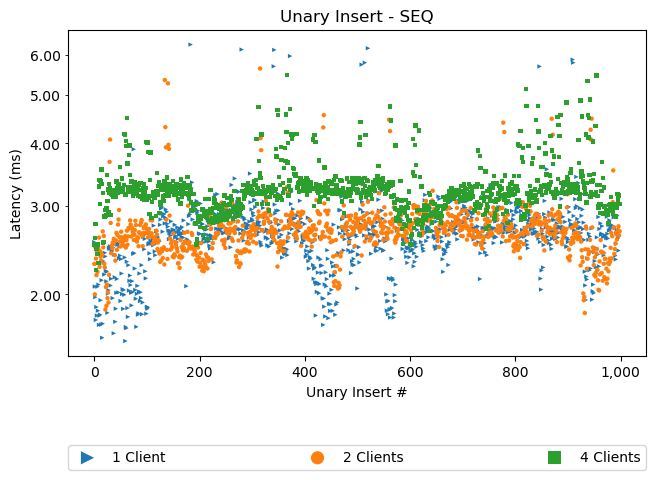

In [6]:
unaryPlots("INSERT_UNARY_SEQ", "TimescaleDB", targetThreads, client_ips, logScale=True)


## Experiment – UNARY INSERT (RND)
> Perform experiments


In [ ]:
runWorkload(
    "INSERT_UNARY_RAND",
    targetThreads,
    server_local_ips[server_ips[0]],
    9493,
    "TimescaleDB",
    client_ips,
    1000,
    0,
    serverGroup,
    SERVER_WORKING_DIR,
    "ubuntu",
)


> Visualization

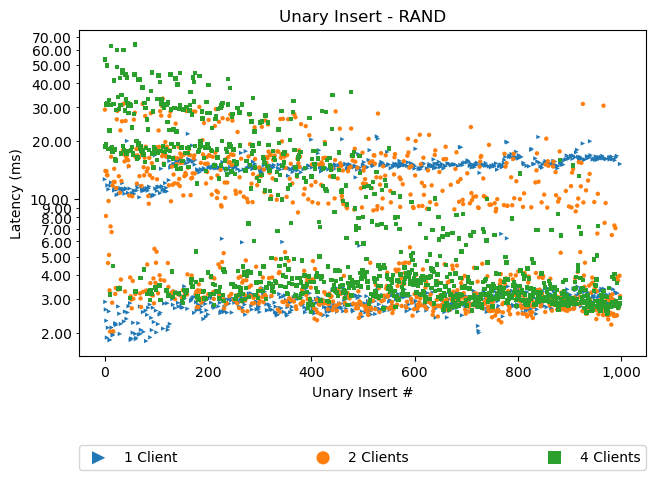

In [15]:
unaryPlots("INSERT_UNARY_RAND", "TimescaleDB", targetThreads, client_ips, logScale=True)


## Experiment – BATCH INSERT (SEQ)
> Perform experiments


In [6]:
runWorkload(
    "INSERT_BATCH_SEQ",
    targetThreads,
    server_local_ips[server_ips[0]],
    9493,
    "TimescaleDB",
    client_ips,
    1000,
    10,
    serverGroup,
    SERVER_WORKING_DIR,
    "ubuntu",
)


[Benchmark: 1] - Schedule workload on 1744687870
[Benchmark: 1] [Client: 64.131.114.158] - Time now: 1744687817 | Delta: 53
[Benchmark: 1] [Client: 64.131.114.158] - Downloaded 1 result files
[Benchmark: 1] [Server] - Downloaded system stats files
[Benchmark: 2] - Schedule workload on 1744688353
[Benchmark: 2] [Client: 64.131.114.158] - Time now: 1744688300 | Delta: 53
[Benchmark: 2] [Client: 64.131.114.158] - Downloaded 2 result files
[Benchmark: 2] [Server] - Downloaded system stats files
[Benchmark: 4] - Schedule workload on 1744688841
[Benchmark: 4] [Client: 64.131.114.158] - Time now: 1744688788 | Delta: 53
[Benchmark: 4] [Client: 64.131.114.158] - Downloaded 4 result files
[Benchmark: 4] [Server] - Downloaded system stats files


> Visualization

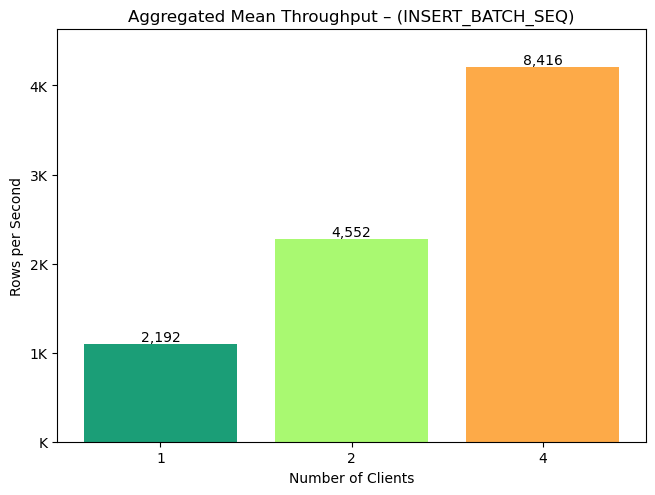

In [7]:
batchPlots("INSERT_BATCH_SEQ", "TimescaleDB", targetThreads, client_ips)


## Experiment – BATCH INSERT (RND)
> Perform experiments


In [7]:
runWorkload(
    "INSERT_BATCH_RAND",
    targetThreads,
    server_local_ips[server_ips[0]],
    9493,
    "TimescaleDB",
    client_ips,
    1000,
    10,
    serverGroup,
    SERVER_WORKING_DIR,
    "ubuntu",
)


[Benchmark: 1] - Schedule workload on 1744497831
[Benchmark: 1] [Client: 64.131.114.158] - Time now: 1744497778 | Delta: 53
[Benchmark: 1] [Client: 64.131.114.158] - Downloaded 1 result files
[Benchmark: 1] [Server] - Downloaded system stats files
[Benchmark: 2] - Schedule workload on 1744498313
[Benchmark: 2] [Client: 64.131.114.158] - Time now: 1744498260 | Delta: 53
[Benchmark: 2] [Client: 64.131.114.158] - Downloaded 2 result files
[Benchmark: 2] [Server] - Downloaded system stats files
[Benchmark: 4] - Schedule workload on 1744498801
[Benchmark: 4] [Client: 64.131.114.158] - Time now: 1744498748 | Delta: 53
[Benchmark: 4] [Client: 64.131.114.158] - Downloaded 4 result files
[Benchmark: 4] [Server] - Downloaded system stats files


> Visualization

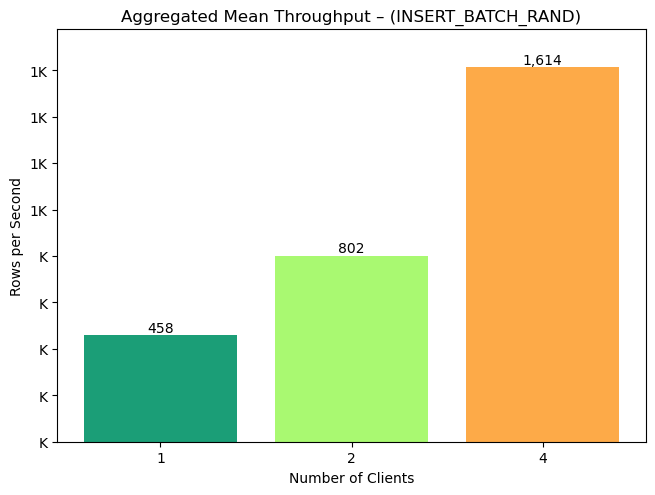

In [8]:
batchPlots("INSERT_BATCH_RAND", "TimescaleDB", targetThreads, client_ips)


## Bootstrap Database

> Reboot server to a fresh state to avoid becoming non-accessible from public network

In [ ]:
allGroup.run(f"sudo shutdown -r +1", hide=True)
allGroup.close()

# Buffer of reboot
time.sleep(70)

for ip in server_ips + client_ips:
    server.wait_for_tcp(ip, 22, timeout=1200)


<div class="alert alert-block alert-info">Note: This is required so that there's actual data for clients to query from</div>

In [5]:
serverGroup.put("../../scripts/restoreDB.sh")
serverGroup.close()

# Restore DB
serverGroup.run(f"bash restoreDB.sh CHI@UC TimescaleDB {SERVER_WORKING_DIR}")
serverGroup.close()

# Keep checking if job is done running in tmux window
checkTmuxJobIsDone(serverGroup)


duplicate session: XStore


True

## Experiment – UNARY QUERY (SEQ)
> Perform experiments


In [12]:
runWorkload(
    "QUERY_UNARY_SEQ",
    targetThreads,
    server_local_ips[server_ips[0]],
    9493,
    "TimescaleDB",
    client_ips,
    1000,
    0,
    serverGroup,
    SERVER_WORKING_DIR,
    "ubuntu",
)


[Benchmark: 1] - Schedule workload on 1744523181
[Benchmark: 1] [Client: 64.131.114.158] - Time now: 1744523128 | Delta: 53
[Benchmark: 1] [Client: 64.131.114.158] - Downloaded 1 result files
[Benchmark: 1] [Server] - Downloaded system stats files
[Benchmark: 2] - Schedule workload on 1744523663
[Benchmark: 2] [Client: 64.131.114.158] - Time now: 1744523609 | Delta: 54
[Benchmark: 2] [Client: 64.131.114.158] - Downloaded 2 result files
[Benchmark: 2] [Server] - Downloaded system stats files
[Benchmark: 4] - Schedule workload on 1744524149
[Benchmark: 4] [Client: 64.131.114.158] - Time now: 1744524096 | Delta: 53
[Benchmark: 4] [Client: 64.131.114.158] - Downloaded 4 result files
[Benchmark: 4] [Server] - Downloaded system stats files


> Visualization

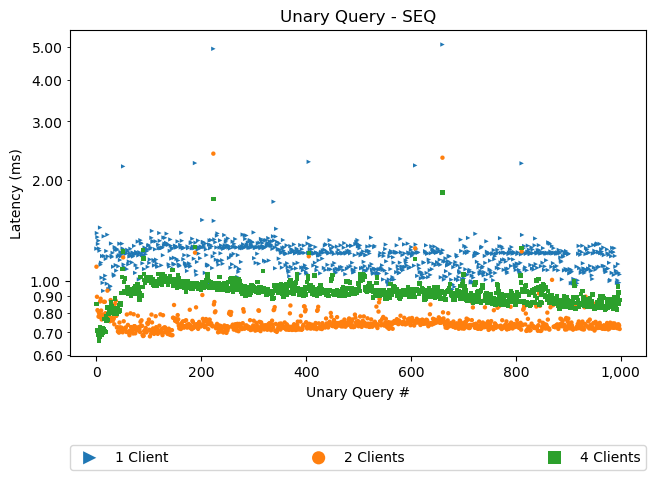

In [13]:
unaryPlots("QUERY_UNARY_SEQ", "TimescaleDB", targetThreads, client_ips, logScale=True)


## Experiment – UNARY QUERY (RND)
> Perform experiments

In [14]:
runWorkload(
    "QUERY_UNARY_RAND",
    targetThreads,
    server_local_ips[server_ips[0]],
    9493,
    "TimescaleDB",
    client_ips,
    1000,
    0,
    serverGroup,
    SERVER_WORKING_DIR,
    "ubuntu",
)


[Benchmark: 1] - Schedule workload on 1744526829
[Benchmark: 1] [Client: 64.131.114.158] - Time now: 1744526776 | Delta: 53
[Benchmark: 1] [Client: 64.131.114.158] - Downloaded 1 result files
[Benchmark: 1] [Server] - Downloaded system stats files
[Benchmark: 2] - Schedule workload on 1744527309
[Benchmark: 2] [Client: 64.131.114.158] - Time now: 1744527256 | Delta: 53
[Benchmark: 2] [Client: 64.131.114.158] - Downloaded 2 result files
[Benchmark: 2] [Server] - Downloaded system stats files
[Benchmark: 4] - Schedule workload on 1744527796
[Benchmark: 4] [Client: 64.131.114.158] - Time now: 1744527742 | Delta: 54
[Benchmark: 4] [Client: 64.131.114.158] - Downloaded 4 result files
[Benchmark: 4] [Server] - Downloaded system stats files


> Visualization

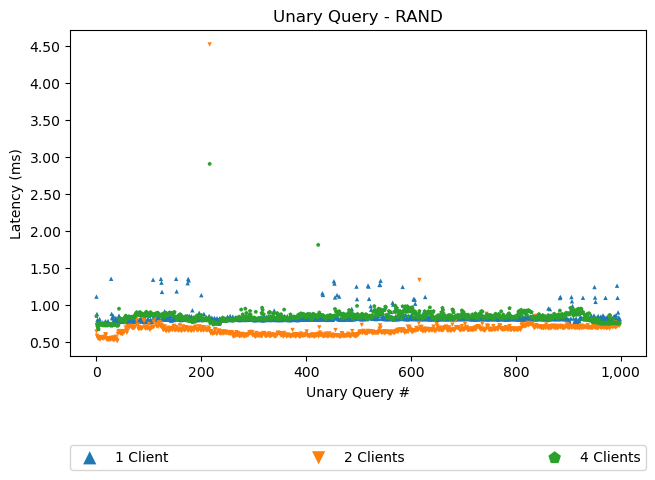

In [15]:
unaryPlots("QUERY_UNARY_RAND", "TimescaleDB", targetThreads, client_ips)


## Experiment – BATCH QUERY (SEQ)
> Perform experiments


In [13]:
runWorkload(
    "QUERY_BATCH_SEQ",
    targetThreads,
    server_local_ips[server_ips[0]],
    9493,
    "TimescaleDB",
    client_ips,
    100,
    1000,
    serverGroup,
    SERVER_WORKING_DIR,
    "ubuntu",
)


[Benchmark: 1] - Schedule workload on 1745450360
[Benchmark: 1] [Client: 64.131.114.158] - Time now: 1745450307 | Delta: 53
[Benchmark: 1] [Client: 64.131.114.158] - Downloaded 1 result files
[Benchmark: 1] [Server] - Downloaded system stats files
[Benchmark: 2] - Schedule workload on 1745450840
[Benchmark: 2] [Client: 64.131.114.158] - Time now: 1745450786 | Delta: 54
[Benchmark: 2] [Client: 64.131.114.158] - Downloaded 2 result files
[Benchmark: 2] [Server] - Downloaded system stats files
[Benchmark: 4] - Schedule workload on 1745451325
[Benchmark: 4] [Client: 64.131.114.158] - Time now: 1745451272 | Delta: 53
[Benchmark: 4] [Client: 64.131.114.158] - Downloaded 4 result files
[Benchmark: 4] [Server] - Downloaded system stats files


> Visualization

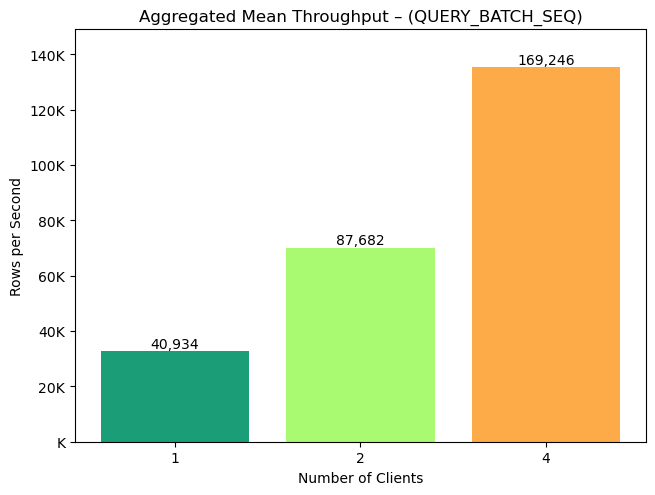

In [14]:
batchPlots("QUERY_BATCH_SEQ", "TimescaleDB", targetThreads, client_ips, 100)


## Experiment – BATCH QUERY (RND)
> Perform experiments


In [9]:
runWorkload(
    "QUERY_BATCH_RAND",
    targetThreads,
    server_local_ips[server_ips[0]],
    9493,
    "TimescaleDB",
    client_ips,
    1000,
    10,
    serverGroup,
    SERVER_WORKING_DIR,
    "ubuntu",
)


[Benchmark: 1] - Schedule workload on 1745445976
[Benchmark: 1] [Client: 64.131.114.158] - Time now: 1745445923 | Delta: 53
[Benchmark: 1] [Client: 64.131.114.158] - Downloaded 1 result files
[Benchmark: 1] [Server] - Downloaded system stats files
[Benchmark: 2] - Schedule workload on 1745446456
[Benchmark: 2] [Client: 64.131.114.158] - Time now: 1745446403 | Delta: 53
[Benchmark: 2] [Client: 64.131.114.158] - Downloaded 2 result files
[Benchmark: 2] [Server] - Downloaded system stats files
[Benchmark: 4] - Schedule workload on 1745446943
[Benchmark: 4] [Client: 64.131.114.158] - Time now: 1745446890 | Delta: 53
[Benchmark: 4] [Client: 64.131.114.158] - Downloaded 4 result files
[Benchmark: 4] [Server] - Downloaded system stats files


> Visualization

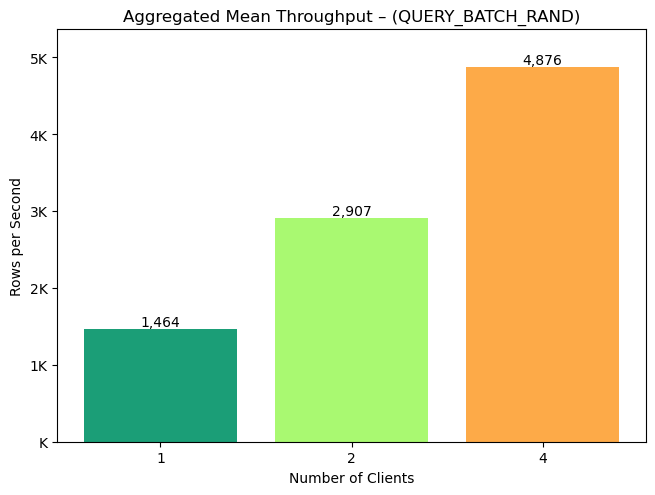

In [10]:
batchPlots("QUERY_BATCH_RAND", "TimescaleDB", targetThreads, client_ips)
